# 6 single doublepads - V01
This variant has an effective Q for resonators around 200

In [129]:
import skrf as rf
from math import pi
from skrf.media.cpw import CPW
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from modeling.utils.resonators import cpw_cl_ll, resonator_kappa
from modeling.utils.network import assemble_network
from modeling.utils.qubits import get_Ic_from_Lj
from qucat import Network,L,J,C,R
from modeling.qubits.clockmon.libraries.clockmon_library import clockmon_coupling_libraries, clockmon_library, clockmon_cqr_to_ground
from modeling.elements.smooth_capacitor.libraries.smooth_capacitor_library import digit_tee_library, digit_tee_ck_to_ground, get_ck
from scqubits import Transmon
from modeling.resonance_fit import ResFit
from scipy.optimize import fsolve

In [130]:
smooth_capacitor_lib = digit_tee_library(deembed = [300, 200])
ck_to_ground = digit_tee_ck_to_ground(deembed=[300, 200])
clockmon_lib = clockmon_library(deembed = 200) 
cqr_to_ground = clockmon_cqr_to_ground(deembed = 200)

In [131]:
planck_h = 6.62607015e-34
e_charge = 1.60217663e-19
phi0 =  2.067833848e-15 # Wb

a = 10e-6
b = 6e-6
ep_r = 11.45

nb_qubits = 4
rr_freq_target = np.array([6.837e9, 7.032e9, 7.251e9, 7.44e9])
qubit_freq_target = np.array([5.132e9, 5.336e9, 4.9e9, 5.780e9])
c_sigma = 90.47e-15
kappa_target = 0.5e6#*np.sqrt(10)#0.5e6 # This is the target kappa for the resonators BEFORE applying the Purcell filter. If the Purcell filter is applied, the effective kappa will be higher and can be determined through resonance fitting.
target_parameters = {
    "chi": 1.45e6,
    "qubit_frequency": qubit_freq_target,
    "rr_frequencies_target": rr_freq_target,
    "c_sigma_unloaded": c_sigma
}
Z0 = CPW(w = a, s = b, ep_r = ep_r).z0[0].real
l_r = Z0*pi/(4*pi*rr_freq_target)
c_r = 1/((2*pi*rr_freq_target)**2*l_r)

In [132]:
def minimize_func(x, c_r = None, l_r = None, target_qubit_frequency = None):
    cir = Network([
        C(0,1,c_sigma - x[0]*1e-15), # transmon
        J(0,1,'Lj'),
        C(0,2,c_r - x[0]*1e-15), # resonator
        L(0,2,l_r),
        C(1,2, x[0]*1e-15), # coupling capacitor
    ])
    err_chi = abs(cir.kerr(Lj = x[1]*1e-9)[0,1]/2 - target_parameters["chi"])*1e3
    
    H = cir.hamiltonian(modes = [0, 1],
                        taylor = 6,
                        excitations = [10, 10],
                        Lj = x[1]*1e-9)
    ee = H.eigenenergies().real
    ee -= ee[0]
    err_freq = abs(ee[1] - target_qubit_frequency)
    return err_chi, err_freq

In [133]:
cqrs = np.zeros((nb_qubits))
Ljs = np.zeros((nb_qubits))
for i in range(nb_qubits):
    cqr, lj = fsolve(minimize_func, [10, 10], args =(c_r[i], l_r[i], qubit_freq_target[i]))
    cqrs[i] = cqr*1e-15
    Ljs[i] = lj*1e-9

print(cqrs)
print(Ljs)

[5.87481593e-15 5.59654440e-15 7.77472190e-15 5.01419074e-15]
[9.74622260e-09 9.04554322e-09 1.06430852e-08 7.75938289e-09]


In [134]:
Ic = get_Ic_from_Lj(Ljs)
EC = e_charge**2/(c_sigma)/2/planck_h
Ej = Ic*phi0/2/pi/planck_h

anharmonicities = np.zeros(4)
for i in range(4):
    transmon = Transmon(EJ = Ej[i], EC=EC, ng = 0, ncut = 31)
    anharmonicities[i] = transmon.anharmonicity()

In [135]:
anharmonicities

array([-2.37871562e+08, -2.36791813e+08, -2.39229814e+08, -2.34754790e+08])

Energy dispersion is  1.0022840118408203e-07 GHz


Spectral data:   0%|          | 0/101 [00:00<?, ?it/s]

(<Figure size 640x480 with 1 Axes>,
 <Axes: xlabel='$n_g$', ylabel='energy [GHz]'>)

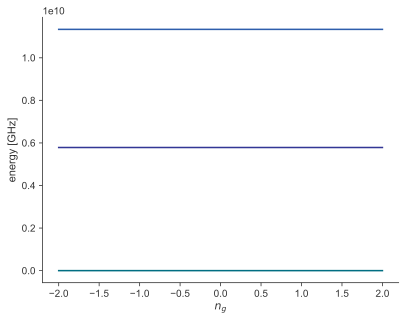

In [136]:
ng_list = np.linspace(-2, 2, 101)
e01_list = []
for ng in ng_list:
    e01_list.append(Transmon(EJ=Ej[0], EC=EC, ng=ng, ncut=31).E01())
e01_min = min(e01_list)
e01_max = max(e01_list)
delta_e01 = (e01_max - e01_min)/1e9
print("Energy dispersion is ", delta_e01, "GHz")
transmon.plot_evals_vs_paramvals('ng', ng_list, evals_count=3, subtract_ground=True)

In [137]:
corrected_rr_freq = np.zeros((nb_qubits))
for i in range(nb_qubits):
    cir = Network([
        C(0,1,c_sigma- cqrs[i]), # transmon
        J(0,1,'Lj'),
        C(0,2,c_r[i] - cqrs[i]), # resonator
        L(0,2,l_r[i]),
        C(1,2, cqrs[i]), # coupling capacitor
        R(0, 2, 1e6)
        ])
    # f,k,A,chi = 
    cir.f_k_A_chi(pretty_print=True, Lj = Ljs[i])
    ham = cir.hamiltonian(modes = [0, 1],
                        taylor = 6,
                        excitations = [10, 10],
                        Lj = Ljs[i])
    ee = ham.eigenenergies()
    ee -= ee[0]
    corrected_rr_freq[i] = ee[2]


         mode |       freq.  |       diss.  |       anha.  |
            0 |     5.35 GHz |     1.79 kHz |      211 MHz |
            1 |     6.85 GHz |      546 kHz |     9.95 kHz |

Kerr coefficients (diagonal = Kerr, off-diagonal = cross-Kerr)
         mode |         0    |         1    |
            0 |      211 MHz |              |
            1 |      2.9 MHz |     9.95 kHz |

         mode |       freq.  |       diss.  |       anha.  |
            0 |     5.56 GHz |     1.89 kHz |      211 MHz |
            1 |     7.04 GHz |      561 kHz |     9.95 kHz |

Kerr coefficients (diagonal = Kerr, off-diagonal = cross-Kerr)
         mode |         0    |         1    |
            0 |      211 MHz |              |
            1 |      2.9 MHz |     9.95 kHz |

         mode |       freq.  |       diss.  |       anha.  |
            0 |     5.12 GHz |     1.39 kHz |      212 MHz |
            1 |     7.27 GHz |      580 kHz |     9.94 kHz |

Kerr coefficients (diagonal = Kerr, off-diag

 C:\Users\moret\AppData\Local\Temp\ipykernel_21348\664116265.py: 19

In [138]:
cir = Network([
    C(0,1,c_sigma- cqrs[i]), # transmon
    J(0,1,'Lj'),
    C(0,2,c_r[i] - cqrs[i]), # resonator
    L(0,2,l_r[i]),
    C(1,2, cqrs[i]), # coupling capacitor
    ])

In [139]:
g = 2*np.pi*EC/ (e_charge) * (Ej/EC/2)**(1/4) * cqrs / (c_r) * np.sqrt(2*planck_h * rr_freq_target * (c_r))
delta = (rr_freq_target - transmon.E01()) * 2*np.pi

lamb_shift = 2*g**2 / delta / 2 / np.pi
g/2/np.pi

array([1.09564718e+08, 1.09372997e+08, 1.50430481e+08, 1.07730072e+08])

In [140]:
cqrs

array([5.87481593e-15, 5.59654440e-15, 7.77472190e-15, 5.01419074e-15])

In [141]:
def minimize_for_ck(x, resonator_frequency):
    k = resonator_kappa(resonator_frequency, x[0]*1e-15, Z0)/ 2/ pi / np.sqrt(2)
    return abs(k - kappa_target)

cks = np.zeros((nb_qubits))
for i in range(nb_qubits):
    cks[i] = abs(fsolve(minimize_for_ck, 5, args = (rr_freq_target[i]))[0]*1e-15)

In [142]:
cqr_to_ground(cqrs)

array([1.66205909e-14, 1.58501779e-14, 2.22278538e-14, 1.42525339e-14])

In [143]:
coupler_width_given_c_qr, c_sigma_given_coupler_width = clockmon_coupling_libraries()
ck_given_coupling = get_ck()

# scikit-rf network

In [144]:
fl_traits = pd.read_csv("single_doublepads_03.csv").values[0][1:]
tee_size = pd.read_csv("single_doublepads_03.csv").values[1][1:]
res_length = pd.read_csv("single_doublepads_03.csv").values[2][1:]

tee_size = tee_size[pd.isna(tee_size) == 0]
res_length =res_length[pd.isna(res_length) == 0]

transmission_line_tee_points = [
    float(fl_traits[0]), # From input launcher to feedline capacitor
    fl_traits[1] + (a + 2*b)/2, # From feedline capacitor to tee0
    fl_traits[2] + (a + 2*b), # From tee0 to tee1
    fl_traits[3] + (a + 2*b), # From tee1 to tee2
    fl_traits[4] + (a + 2*b), # From tee2 to tee3
    # fl_traits[5] + (a + 2*b), # From tee3, to tee4 
    # fl_traits[6] + (a + 2*b), # From tee4, to tee5
    fl_traits[5] + (a + 2*b), # From tee5, to tee6 (from tee6 we split into output launcher and feedline resonator tail)
    fl_traits[6] + (a + 2*b)/2, # From tee6 to output launcher
    fl_traits[7] + 30, # from tee6 to ground (feedline resonator tail endpoint)
]

feedline_res_length = fl_traits[1] + (a + 2*b)/2 + \
    fl_traits[2] + (a + 2*b) + \
    fl_traits[3] + (a + 2*b) + \
    fl_traits[4] + (a + 2*b) + \
    fl_traits[5] + (a + 2*b) + \
    fl_traits[6] + 30 + fl_traits[7] + (a + 2*b)/2
qb_pos_0 = fl_traits[1] + (a + 2*b)/2
qb_pos_1 = qb_pos_0 + fl_traits[2] + (a + 2*b)
qb_pos_2 = qb_pos_1 + fl_traits[3] + (a + 2*b)
qb_pos_3 = qb_pos_2 + fl_traits[4] + (a + 2*b)

In [145]:
fl_traits[1]

7247.597

In [146]:
def resonance_profile(x, total_length, order):
    return abs(np.cos(2*np.pi*x*(order + 1/2)/total_length/2))

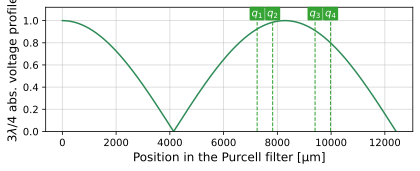

In [147]:
import numpy as np
import matplotlib.pyplot as plt

# ---------------- assumed to exist in your workspace ----------------
# resonance_profile(x, feedline_res_length, order=1)
# feedline_res_length
# qb_pos_0, qb_pos_1, qb_pos_2, qb_pos_3
# --------------------------------------------------------------------

# same palette as previous plot
cmap = plt.get_cmap("tab10")
box_face = cmap(2)           # green-ish like before
profile_color = "#2E8B57"    # same green used earlier for profile line

# generate x and profile
xdata = np.linspace(0, feedline_res_length, 1001)
profile = resonance_profile(xdata, feedline_res_length, order=1)

fig, ax = plt.subplots(figsize=(6, 2.5))
ax.plot(xdata, profile, color=profile_color, lw=1.5)

# vertical lines marking qubit positions
qb_positions = [qb_pos_0, qb_pos_1, qb_pos_2, qb_pos_3]
ax.vlines(qb_positions, ymin=0.0, ymax=1.0, colors=box_face, linestyles="--", lw=1.0)

# less-round boxed labels placed just above the profile
bbox_props = dict(boxstyle="round,pad=0.20,rounding_size=0.08",
                  facecolor=box_face, alpha=0.95, edgecolor="none")
labels = [r"$q_1$", r"$q_2$", r"$q_3$", r"$q_4$"]
y_box = 1.02            # y position in data coordinates (just above ymax=1.0)

for pos, lab in zip(qb_positions, labels):
    ax.text(pos, y_box, lab,
            ha="center", va="bottom",
            fontsize=10, color='white' if (0.2126*box_face[0] + 0.7152*box_face[1] + 0.0722*box_face[2]) < 0.55 else 'black',
            bbox=bbox_props)

# grid, labels, and limits
ax.grid(True, alpha=0.5)
ax.set_xlabel(r"Position in the Purcell filter [μm]", fontsize=12)
ax.set_ylabel(r"$3\lambda/4$ abs. voltage profile", fontsize=12)
ax.set_ylim(0.0, 1.12)   # room for the boxes above the profile
ax.tick_params(labelsize=10)
plt.tight_layout()
plt.savefig("voltage_profile_v03.svg", transparent=True)
plt.show()


In [148]:
xdata.max()

12419.75711

In [149]:
def minimize_for_ck(x, resonator_frequency, correction_to_ck):
    k = resonator_kappa(resonator_frequency, x[0]*1e-15, Z0)/ 2/ pi / np.sqrt(2)
    k = k*correction_to_ck
    return abs(k - kappa_target)
corrections_to_ck = resonance_profile(np.array([qb_pos_0, qb_pos_1, qb_pos_2, qb_pos_3]), feedline_res_length, order = 1)
cks = np.zeros((nb_qubits))
for i in range(nb_qubits):
    cks[i] = fsolve(minimize_for_ck, 5, args = (rr_freq_target[i], corrections_to_ck[i]))[0]*1e-15
cks = np.abs(cks)

# Readout resonators (lambda/4)
rr_cap_to_ground = cqr_to_ground(cqrs)
digit_cap_inductance = 1.6210000000000005e-11 # Simulate this
tee_cap_inductance = 3.1509999999999996e-11 # Simulate this
c_l, l_l = cpw_cl_ll(a, b, ep_r)
v_ph = 1/np.sqrt(c_l*l_l)
unloaded_wg_lengths = v_ph / rr_freq_target / 4
l_r_loaded = 1/2 * Z0 * np.sqrt((unloaded_wg_lengths*c_l)*
                                (unloaded_wg_lengths*l_l - digit_cap_inductance - tee_cap_inductance))
c_r_loaded = 2/(np.pi**2 * Z0)*np.sqrt((unloaded_wg_lengths*c_l - rr_cap_to_ground - ck_to_ground(cks))*
                                (unloaded_wg_lengths*l_l))
c_r_loaded -= cqrs
c_r_loaded -= cks
resonator_waveguide_lengths = np.array(np.pi * np.sqrt((c_r_loaded * l_r_loaded) / (c_l*l_l)))
print(f"Waveguide lengths: {resonator_waveguide_lengths*1e6} um")

for i in range(nb_qubits):
    coupler_width = coupler_width_given_c_qr(cqrs[i])
    finger_control = ck_given_coupling(cks[i])
    print(f"Coupler width for qubit {i}: {coupler_width:.5} um")
    print(f"Finger control for qubit {i}: {finger_control:.5}")
    print(f"Resonator length for qubit {i}: {resonator_waveguide_lengths[i]*1e6:.5} um")

Waveguide lengths: [4099.00430649 3993.39913535 3819.11906166 3767.89704141] um
Coupler width for qubit 0: 188.59 um
Finger control for qubit 0: 2.1337
Resonator length for qubit 0: 4099.0 um
Coupler width for qubit 1: 177.2 um
Finger control for qubit 1: 2.0722
Resonator length for qubit 1: 3993.4 um
Coupler width for qubit 2: 268.02 um
Finger control for qubit 2: 2.0667
Resonator length for qubit 2: 3819.1 um
Coupler width for qubit 3: 153.53 um
Finger control for qubit 3: 2.0891
Resonator length for qubit 3: 3767.9 um


In [150]:
resonator_capacitance = c_r - cks -  cqrs
cfl = 5e-14
options = {
    "qubit_c": np.array([c_sigma]*nb_qubits),
    "qubit_l": Ljs,
    "readout_resonator_c": resonator_capacitance,
    "readout_resonator_l": l_r,
    "ck": cks,
    "ck_to_ground": ck_to_ground(cks),

    "cqr": cqrs,
    "feedline_traits": transmission_line_tee_points,
    "cfl": cfl,
    "cfl_to_ground": ck_to_ground(cfl),

    "frequency": [4, 8.5],
    "n_points": 2001,
    "type": "feedline_resonator",
    "a": a,
    "b": b,
    "ep_r": ep_r,
    "substrate_thickness": 550e-6
}

2-Port Network: '',  4.0-8.5 GHz, 2001 pts, z0=[50.+0.j 50.+0.j]


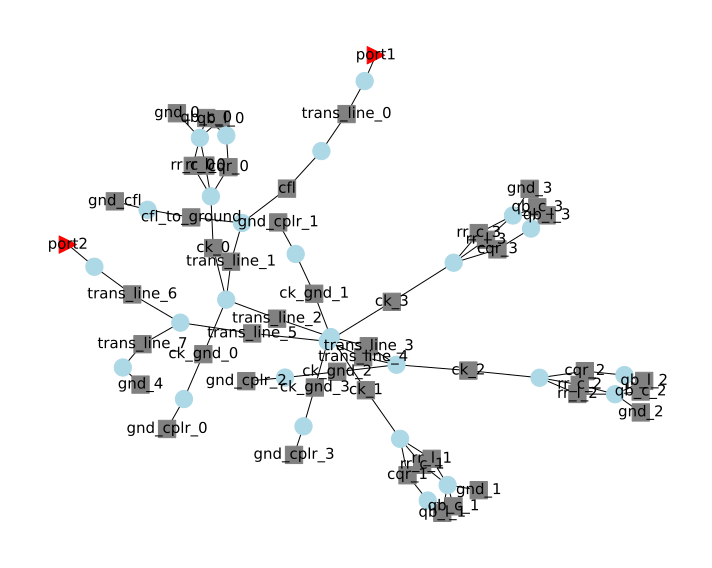

In [151]:
cnx = assemble_network(options)
cir = rf.Circuit(cnx)

cir.plot_graph(network_labels=True, network_fontsize=15,
               port_labels=True, port_fontsize=15,
               edge_fontsize=10)

# Get the resulting Network from the 'network' parameter:
ntw = cir.network
print(ntw)

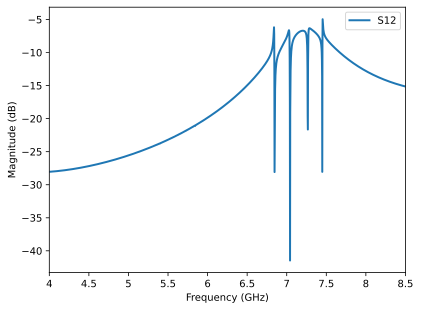

In [152]:
ntw.plot_s_db(m=0, n=1, lw=2)

In [153]:
# We can make basic guesses by zooming the ntw.s plot
kappa_guess = 5e6 # FHWM
freq = 7e9
Q = freq / kappa_guess / np.sqrt(2)
Q

989.9494936611665

In [154]:
# From lower to higher freq (FWHM || fit)
# 1769 || 259
# 1580 || 246
# 1700 || 351
# 1880 || 305
# 1790 || 360
# 1829 || 435

In [155]:
# We can attempt to find the resonator Q by fitting the resonance
# initial_params = [1, 1e3, 1e5, 6, 2, 0, 0, 0]
# fitter = ResFit(ntw, 150, 400, ideal = False)
# fitter.fit_resonance(initial_params=initial_params)
# fitter.plot_resonance()

### Purcell filter Quality estimation
We cannot extract Q based on simple formulas because the feedline is split closer to the launchpad (tail length modifies significantly the S21). <br>
We can roughly estimate it by visually inspecting the linewidth, or fitting.

In [156]:
options_only_purcell = {
    "qubit_c": np.array([c_sigma]*nb_qubits),
    "qubit_l": Ljs,
    "readout_resonator_c": resonator_capacitance,
    "readout_resonator_l": l_r,
    "ck": np.array([0,0,0,0,0,0]), # We remove the resonataors
    "ck_to_ground": ck_to_ground(cks),

    "cqr": cqrs,
    "feedline_traits": transmission_line_tee_points,
    "cfl": cfl,
    "cfl_to_ground": ck_to_ground(cfl),

    "frequency": [5, 9],
    "n_points": 2001,
    "type": "feedline_resonator",
    "a": a,
    "b": b,
    "ep_r": ep_r,
    "substrate_thickness": 550e-6
}
cnx_only_purcell = assemble_network(options_only_purcell)
cir_only_purcell = rf.Circuit(cnx_only_purcell)
# Get the resulting Network from the 'network' parameter:
ntw_only_purcell = cir_only_purcell.network
print(ntw_only_purcell)

2-Port Network: '',  5.0-9.0 GHz, 2001 pts, z0=[50.+0.j 50.+0.j]


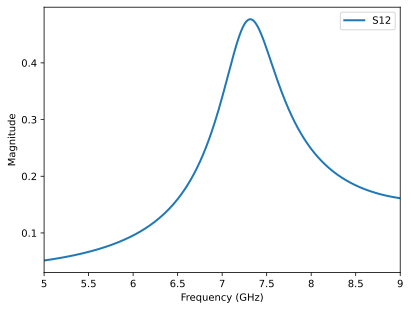

In [157]:
ntw_only_purcell.plot_s_mag(m=0, n=1, lw=2)

In [158]:
# initial_params = [1, 20, 1e2, 1, 1, 0, 0, 0]
# fitter = ResFit(ntw_only_purcell, 0, 2000, ideal = False, fit_type = "S11", poly_noise = False)
# fitter.fit_resonance(initial_params=initial_params)
# fitter.plot_resonance()

In [159]:
(1/10.28 + 1/11)**(-1)

5.31390977443609

In [160]:
7.382e9 / 1.3e9

5.678461538461539

In [161]:
# T1 Purcell:
delta = rr_freq_target - target_parameters["qubit_frequency"]
k_purcell = kappa_target* (g/2/np.pi/delta)**2
T1_purcell_pre_filter = 1/(2*np.pi*k_purcell)
print(T1_purcell_pre_filter/1e-6)

[77.08279384 76.53879063 77.74700985 75.57747893]


In [162]:
kappa_filtered = (1130/rr_freq_target)**(-1)
delta = rr_freq_target - target_parameters["qubit_frequency"]
k_purcell = kappa_filtered* (g/2/np.pi/delta)**2
T1_purcell_pre_filter = 1/(2*np.pi*k_purcell)
print(T1_purcell_pre_filter/1e-6)

[6.37001295 6.14966108 6.05806931 5.73941876]


In [163]:
kappa_filtered

array([6050442.47787611, 6223008.84955752, 6416814.15929204,
       6584070.79646018])

In [164]:
# T1 Purcell - adapting the formula to the filter presence (eq. 178 of https://doi.org/10.1063/1.5089550):

purcell_Q = 16 #fitter.popt[1] #7.5e9/ 500e6#(resonator_kappa(7.5e9, cfl, Z0) / 2/pi) # corresponding to a kappa FWHM of 500 MHz
delta = rr_freq_target - target_parameters["qubit_frequency"]
actual_kappa_readout_resonator = resonator_kappa(rr_freq_target, cks, Z0)/ 2/ pi# / np.sqrt(2)
k_purcell_ = actual_kappa_readout_resonator* (g/2/np.pi/delta)**2

k_purcell_ = kappa_target* (g/2/np.pi/delta)**2
T1_purcell = 1/(2*np.pi*k_purcell_) / (qubit_freq_target/ 2 / purcell_Q / delta)
print(T1_purcell)

[0.00081949 0.00077847 0.00119369 0.00069458]


In [165]:
# For when we'll need chargelines/fluxlines: https://quantumcomputing.stackexchange.com/questions/33136/how-to-estimate-the-losses-of-a-transmon-qubit-to-its-flux-bias-line

In [166]:
finger_control_feedline = ck_given_coupling(cfl)
print(f"Finger control probeline capacitor: {finger_control_feedline:.5}")

Finger control probeline capacitor: 4.2527


In [167]:
df = pd.DataFrame(index=['qb0','qb1','qb2', 'qb3'])
df['resonator 01 [GHz]'] = rr_freq_target / 1e9
df['qubit 01 [GHz]'] = qubit_freq_target / 1e9
df['anharmonicity [MHz]'] = np.floor(anharmonicities / 1e6)
df['chi/2pi [MHz]'] = np.array([target_parameters["chi"]]*4)/1e6
df['g/2pi [MHz]'] = g/2/np.pi * 1e-6
df['C_sigma [fF]'] = np.array([c_sigma]*4) * 1e15
df["Lj [nH]"] = Ljs * 1e9
df['Ic [nA]'] = Ic * 1e9
# df['T1 Purcell [us]'] = np.floor(T1_purcell * 1e6)
# df['T1 Purcell if no filter [us]'] = np.floor(T1_purcell_pre_filter * 1e6)
#df['Resonator Q'] = np.array([1670, 1469, 1915, 1649])
df

,resonator 01 [GHz],qubit 01 [GHz],anharmonicity [MHz],chi/2pi [MHz],g/2pi [MHz],C_sigma [fF],Lj [nH],Ic [nA]
qb0,6.837,5.132,-238.0,1.45,109.564718,90.47,9.746223,33.767542
qb1,7.032,5.336,-237.0,1.45,109.372997,90.47,9.045543,36.383219
qb2,7.251,4.900,-240.0,1.45,150.430481,90.47,10.643085,30.922047
qb3,7.440,5.780,-235.0,1.45,107.730072,90.47,7.759383,42.413937
